# Monte Carlo Uncertainty Analysis for Nonlinear Regression

**Further Reading:** §4.12

## Learning Objectives
After studying this notebook, attending class, asking questions, and reviewing your notes, you should be able to:
* Use simulation to calculate and analyze probabilities.
* Write code to simulate data, add noise, and visually inspect the distribution of fitted parameters through Monte Carlo Uncertainty Analysis.


In [1]:
# load libraries
import scipy.stats as stats
import numpy as np
import scipy.optimize as optimize
import math
import matplotlib.pyplot as plt

## Simulation

See [this notebook](../10-publish/04-Simulation.ipynb) for notes on simulating a problem to calculate probability, mean, variance, and to determine if a population is normal.

## Monte Carlo Error Propagation

### Motivating Example: Cart + Incline

You and a classmate want to measure the acceleration of a cart rolling down an incline plane, but disagree on the best approach. The cart starts at rest and travels distance $l = 1.0$ m. The location of the *finish line* is measured with negligible uncertainty. You (student 1) measure the instantaneous velocity $v = 3.2 \pm 0.1 $ m/s at the finish line. Your classmate (student 2) instead measures the elapsed time $t = 0.63 \pm 0.01$s.


#### Student 1

Using instantaneous velocity, we can acceleration as follows:

$$
a_1 = \frac{v^2}{2l}
$$

First, let's recap the *standard* error propagation approach from our homework.

##### Standard Error Propagation

In [5]:
## Results of 'standard' error analysis (from homework)

# define distance travelled
l = 1 # m 

# define function to calculate a1
calc_a1 = lambda v: v**2 / (2*l)

# define velocity measurement and uncertainty
v = 3.2
v_std = 0.1

# calculate a1
a1 = calc_a1(v)

# estimate gradient with forward finite difference
da1dv = (calc_a1(v + 1E-6) - a1)/(1E-6)

# calculate uncertainty
sigma_a1 = abs(da1dv)*v_std

# report answer
print("Calculated acceleration: ",round(a1,2),"+/-",round(sigma_a1,2),"m/s/s")

Calculated acceleration:  5.12 +/- 0.32 m/s/s


##### Monte Carlo Error Propagation

We can also estimate the uncertainty in $a_1$ using simulation. Below is the **main idea**.

Repeat 1000s of times:
* Add $\mathcal{N}(0,0.1^2)$ uncertainty to velocity measurement
* Recalculate $a_1$ and store result

Then calculate the standard deviation of the stored $a_1$ results. In other words, we are simulated what would happen if we repeated the experiment many many times with an assumed random measurement error.

<div style="background-color: rgba(0,0,255,0.05) ; padding: 10px; border: 1px solid darkblue;"> 
<b>Class Activity</b>: With a partner, complete the code below.
</div>

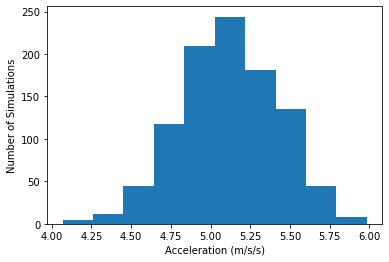

Mean:  5.113776787070997  m/s/s
Median:  5.115916657943146  m/s/s
Standard Deviation:  0.306782158290633  m/s/s


In [27]:
# specify number of simulations
nsim = 1000

# create vector to store the results
a1_sim = np.zeros(nsim)

### BEGIN SOLUTION

# repeat many times
for i in range(0,nsim):
    
    # create normally distributed noise
    # loc = mean
    # scale = standard deviation
    noise = np.random.normal(loc = 0,scale = v_std)
    
    # calculate a1, store result
    a1_sim[i] = calc_a1(v + noise)

### END SOLUTION
    
# create histogram of calculated a1 values
plt.hist(a1_sim)
plt.xlabel("Acceleration (m/s/s)")
plt.ylabel("Number of Simulations")
plt.show()

# print some descriptive statistics
print("Mean: ",np.mean(a1_sim)," m/s/s")
print("Median: ",np.median(a1_sim)," m/s/s")
print("Standard Deviation: ",np.std(a1_sim)," m/s/s")

This standard deviation matches the uncertainty calculated with the error propagation formulas.

#### Student 2

Using instantaneous velocity, we can calculate acceleration as follows:

$$
a_2 = \frac{2 l}{t^2} 
$$

First, lets recap the solution to the homework.

##### Standard Error Propagation

In [7]:
## Results of 'standard' error analysis (from homework)

# define distance travelled
l = 1 # m

# define function to calculate a2
calc_a2 = lambda t: 2*l / t**2

# define time measurement and uncertainty
t = 0.63
t_std = 0.01

# calculate a2
a2 = calc_a2(t)

# estimate gradient with forward finite difference
da2dt = (calc_a2(t + 1E-6) - a2)/(1E-6)

# calculate uncertainty
sigma_a2 = abs(da2dt)*t_std

print("Calculated acceleration: ",round(a2,2),"+/-",round(sigma_a2,2),"m/s/s")

Calculated acceleration:  5.04 +/- 0.16 m/s/s


##### Monte Carlo Error Propagation

<div style="background-color: rgba(0,0,255,0.05) ; padding: 10px; border: 1px solid darkblue;"> 
<b>Class Activity</b>: Apply the Monte Carlo approach to Student 2's calculation. Start by copying and pasting the code from above.
</div>

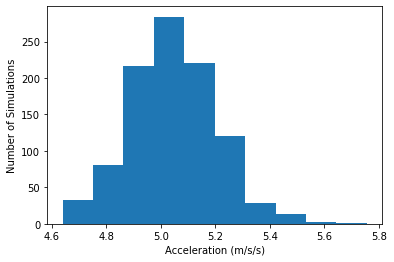

Mean:  5.04614403662456  m/s/s
Median:  5.036806168624843  m/s/s
Standard Deviation:  0.15841862599598272  m/s/s


In [28]:
### BEGIN SOLUTION

# specify number of simulations
nsim = 1000

# create vector to store the results
a2_sim = np.zeros(nsim)

# repeat many times
for i in range(0,nsim):
    
    # create normally distributed noise
    # loc = mean
    # scale = standard deviation
    noise = np.random.normal(loc = 0,scale = t_std)
    
    # calculate a1, store result
    a2_sim[i] = calc_a2(t + noise)
    
# create histogram of calculated a1 values
plt.hist(a2_sim)
plt.xlabel("Acceleration (m/s/s)")
plt.ylabel("Number of Simulations")
plt.show()

# print some descriptive statistics
print("Mean: ",np.mean(a2_sim)," m/s/s")
print("Median: ",np.median(a2_sim)," m/s/s")
print("Standard Deviation: ",np.std(a2_sim)," m/s/s")

### END SOLUTION

## Motivating Example: Michaelis-Menten Enzymatic Reaction Kinetics

The **Michaelis-Menten** equation is an extremely popular model to describe the rate of enzymatic reactions.

$$
\mathrm{E} + \mathrm{S} \leftrightharpoons \mathrm{ES} \rightarrow \mathrm{E} + \mathrm{P}
$$

$$
r = V_{max} \frac{[\mathrm{S}]}{K_M + [\mathrm{S}]}
$$

Additional information: https://en.wikipedia.org/wiki/Michaelis%E2%80%93Menten_kinetics

In [9]:
## Create dataset

# Define exact coefficients
Vmaxexact=2;
Kmexact=5;

# Evaluate model
Sexp = np.array([.3, .4, 0.5, 1, 2, 4, 8, 16]);
rexp = Vmaxexact*Sexp / (Kmexact+Sexp);

# Add some random error to simulate 
rexp += 0.05*np.random.normal(size=len(Sexp))

# Evaluate model to plot smooth curve
S = np.linspace(np.min(Sexp),np.max(Sexp),100)
r = Vmaxexact*S / (Kmexact+S)

## Main Idea

* Use residuals to estimate uncertainty in dependent variable
* Simulate regression procedure 1000s of times, adding random noise to dependent variable
* Examine distribution of fitted values

In [18]:
# variance of residuals
print(sigre)

0.003717977540144133


## Pseudocode

<div style="background-color: rgba(0,0,255,0.05) ; padding: 10px; border: 1px solid darkblue;"> 
<b>Class Activity</b>: Write pseudocode with a partner.
</div>

## Python Hints

Let's say we want to generate a vector with 5 elements, each normally distributed with mean 0 and standard deviation 2. We can do this in one line using Python:

In [19]:
my_vec = np.random.normal(loc = 0,scale = 2,size=(5))
print(my_vec)

[-2.71241136  0.91627376 -0.96646476  2.57309647  0.73030355]


## Implement in Python

<div style="background-color: rgba(0,0,255,0.05) ; padding: 10px; border: 1px solid darkblue;"> 
<b>Class Activity</b>: Implement your pseudocode in Python.
</div>

In [20]:
# Number of Monte Carlo samples
nmc = 1000;

# Number of data points
n = len(rexp)

# Declare a matrix to save the fitted parameters
theta_mc = np.zeros((nmc,2))

# Recall, the standard deviation of the residuals is sigre**0.5

# Perform Monte Carlo simulation
### BEGIN SOLUTION
# Repeat for i = 0 to nmc - 1
for i in range(nmc):
    
    # generate Guassian random noise with mean 0 and standard deviation of sqrt(sigre)
    noise_vector = np.random.normal(loc = 0,scale = sigre**0.5, \
                                    size=(n))
    
    # add noise to the dependent variable
    noisy_data = rexp + noise_vector
    
    # compute the least squares best fit via nonlinear optimization
    # use the determinist nonlinear regression best fit as a starting point
    sol = optimize.least_squares(regression_func,theta,args=(Sexp, noisy_data))
    
    # save solution
    theta_mc[i,:] = sol.x

### END SOLUTION

## Visualize Distribution of Fitted Parameters

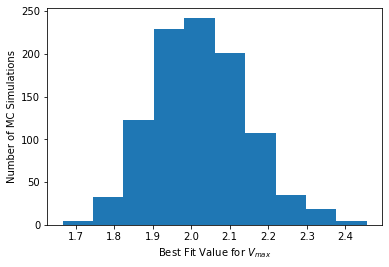

In [21]:
# Histogram for Vmax
plt.hist(theta_mc[:,0])
plt.xlabel("Best Fit Value for $V_{max}$")
plt.ylabel("Number of MC Simulations")
plt.show()

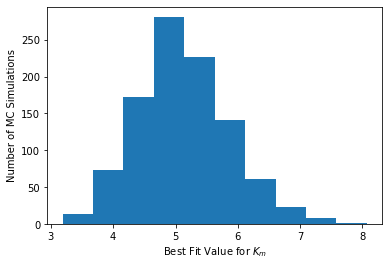

In [22]:
# Histogram for Km
plt.hist(theta_mc[:,1])
plt.xlabel("Best Fit Value for $K_{m}$")
plt.ylabel("Number of MC Simulations")
plt.show()

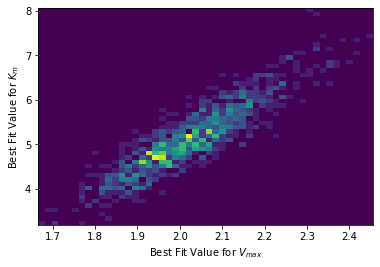

In [23]:
# We can even make a 2D histogram
plt.hist2d(theta_mc[:,0], theta_mc[:,1],bins=50)
plt.xlabel("Best Fit Value for $V_{max}$")
plt.ylabel("Best Fit Value for $K_{m}$")
plt.show()

## Compute Covariance Matrix

In [24]:
## We can calculate covariance in one, carefully constructed line
# For some reason, the NumPy developers choose to assume each ROW is a new variable
# and each COLUMN is a different observation. I would have choose a flipped convention.
# Our 'theta_mc' has each row as a different observation (simulation).
# 'rowvar=False' tells NumPy to flip its convention. This is a great example of
# WHY YOU SHOULD ALWAYS CHECK THE DOCUMENTATION!!!
np.cov(theta_mc,rowvar=False)

array([[0.01497054, 0.08128554],
       [0.08128554, 0.54461604]])